# exp033

levelごとのレコード数

In [16]:
import os
import sys
import traceback
import gc
import random
import pickle
import pathlib
import subprocess
from dataclasses import dataclass
from collections import defaultdict

import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
@dataclass
class Cfg:
    mode = "local_cv" # "local_cv" or "kaggle_inf" 
    exp_name = "exp033"
    input_dir = "/mnt/predict-student-performance-from-game-play/input/"
    output_dir = "/mnt/predict-student-performance-from-game-play/output/"
    prep_dir = "/mnt/predict-student-performance-from-game-play/prep/"
    seed = 42
    n_splits = 5
    best_threshold = 0.630 # local_cvの結果を入れる
cfg = Cfg()

if cfg.mode == "local_cv":
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name), exist_ok=True)
    os.makedirs(os.path.join(cfg.output_dir, cfg.exp_name, "cache"), exist_ok=True)

elif cfg.mode == "kaggle_inf":
    import jo_wilder

In [18]:
params = {
    'objective': 'binary', 
    'boosting': 'gbdt', 
    'learning_rate': 0.1, 
    'metric': 'binary_logloss', 
    'seed': cfg.seed, 
    'feature_pre_filter': False, 
    'lambda_l1': 3.86172588734434e-05, 
    'lambda_l2': 8.164200511365216, 
    'num_leaves': 31, 
    'feature_fraction': 0.4, 
    'bagging_fraction': 0.9437148886789388, 
    'bagging_freq': 1, 
    'min_child_samples': 50
}

In [19]:
features_used_total = [
    'record_cnt'
]

In [20]:
level_group_list = ['0-4', '5-12', '13-22']

event_name_list = [
    'cutscene_click', 'person_click', 'navigate_click',
    'observation_click', 'notification_click', 'object_click',
    'object_hover', 'map_hover', 'map_click', 'checkpoint',
    'notebook_click'
]

name_list = [
    'basic', 'undefined', 'close', 'open', 'prev', 'next'
]

page_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]  

level_list = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22]

In [21]:
def transform_labels_df(labels_):
    """
    labelsデータを整形する
    """
    labels = labels_.copy()
    labels["question"] = labels["session_id"].apply(lambda x: x.split("_")[1].replace("q", "")).astype(int)
    labels["session_id"] = labels["session_id"].apply(lambda x: x.split("_")[0]).astype(int)
    
    # trainの特徴量と結合するためにquestionに対応するlabel_groupを列として設けておく
    labels["level_group"] = ""
    labels.loc[labels["question"]<=3, "level_group"] = "0-4"
    labels.loc[(labels["question"]>=4)&(labels["question"]<=13), "level_group"] = "5-12"
    labels.loc[labels["question"]>=14, "level_group"] = "13-22"

    return labels

In [22]:
class Features:
    def __init__(self, _sessions):
        self.sessions = _sessions.copy()
        self.features = self.sessions[["session_id", "level_group"]].drop_duplicates().copy()

    def _prep(self):
        self.sessions = self.sessions.sort_values(["session_id", "level_group", "elapsed_time"], ignore_index=True)
        self.sessions["elapsed_time_diff"] = self.sessions["elapsed_time"] - self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].shift(1)

    def _record_cnt(self):
        """level_groupごとのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":"record_cnt"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_record_cnt(self):
        """level_groupごと、各event_nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for event in event_name_list:
            new_col = f"{event}_record_cnt"
            tmp = add_features[add_features["event_name"]==event][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _name_record_cnt(self):
        """level_groupごと、各nameのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for name in name_list:
            new_col = f"{name}_record_cnt"
            tmp = add_features[add_features["name"]==name][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _page_record_cnt(self):
        """level_groupごと、各pageのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "page"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for page in page_list:
            new_col = f"page{str(int(page))}_cnt"
            tmp = add_features[add_features["page"]==page][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _level_record_cnt(self):
        """各levelのレコード数
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "level"])["index"].count().reset_index().rename(columns={"index":"cnt"})
        for level in level_list:
            new_col = f"level{str(int(level))}_cnt"
            tmp = add_features[add_features["level"]==level][["session_id", "level_group", "cnt"]].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns={"cnt": new_col})
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_col] = self.features[new_col].fillna(-1)
            else:
                self.features[new_col] = -1

    def _elapsed_time(self):
        """level_groupごと、epapsed_timeのmax - min（経過時間）
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])["elapsed_time"].agg([max,min]).reset_index()
        add_features["elapsed_time"] = add_features["max"] - add_features["min"]
        add_features = add_features[["session_id", "level_group", "elapsed_time"]].copy()
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _coor_mean(self):
        """level_groupごと、座標系の平均値
        """
        add_features = self.sessions.groupby(["session_id", "level_group"])[["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]].mean().reset_index()
        add_features = add_features.rename(columns={"room_coor_x":"room_coor_x_mean", "room_coor_y":"room_coor_y_mean", "screen_coor_x":"screen_coor_x_mean", "screen_coor_y":"screen_coor_y_mean"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_coor_mean(self):
        """level_groupごと、evemt_nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])[coor_cols].mean().reset_index()
        for event in event_name_list:
            if event in ['checkpoint', 'map_hover', 'object_hover']:
                # これらのデータには座標データが存在しないので特徴量化をスキップ
                continue
            col_map = {col:f"{event}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _name_coor_mean(self):
        """level_groupごと、nameごとの座標系の平均値
        """
        coor_cols = ["room_coor_x", "room_coor_y", "screen_coor_x", "screen_coor_y"]
        add_features = self.sessions.groupby(["session_id", "level_group", "name"])[coor_cols].mean().reset_index()
        for name in name_list:
            col_map = {col:f"{name}_elapsed_{col}_mean" for col in coor_cols}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["name"]==name].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1

    def _cat_col_nunique(self, col):
        """level_groupごと、[col]のユニーク数
        """
        add_features = self.sessions.dropna(subset=[col]).drop_duplicates(["session_id", "level_group", col])
        add_features = add_features.groupby(["session_id", "level_group"])["index"].count().reset_index().rename(columns={"index":f"{col}_nunique"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _elapsed_time_diff_agg(self):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["elapsed_time_diff"].agg(["max", "min", "mean", "std"]).reset_index()
        add_features = add_features.rename(columns={"max":"elapsed_time_diff_max", "min":"elapsed_time_diff_min", "mean":"elapsed_time_diff_mean", "std":"elapsed_time_diff_std"})
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")

    def _event_name_elapsed_time_diff_agg(self, agg):
        """level_group、event_nameごとelapsed_timeの差分に関する集計量
        """
        add_features = self.sessions.groupby(["session_id", "level_group", "event_name"])["elapsed_time_diff"].agg(agg).reset_index()
        for event in event_name_list:
            col_map = {a:f"{event}_elapsed_time_diff_{a}" for a in agg}
            new_cols = list(col_map.values())
            tmp = add_features[add_features["event_name"]==event].copy()
            if len(tmp) > 0:
                tmp = tmp.rename(columns=col_map)
                tmp = tmp.drop(columns=["event_name"])
                self.features = self.features.merge(tmp, on=["session_id", "level_group"], how="left")
                self.features[new_cols] = self.features[new_cols].fillna(-1)
            else:
                self.features[new_cols] = -1
                
    def _hover_duration_agg(self, agg):
        """level_groupごと、前後のレコードのelapsed_timeの差分に関する集計量
        """
        col_map = {a:f"hover_duration_{a}" for a in agg}
        add_features = self.sessions.copy()
        add_features = add_features.groupby(["session_id", "level_group"])["hover_duration"].agg(agg).reset_index()
        add_features = add_features.rename(columns=col_map)
        self.features = self.features.merge(add_features, on=["session_id", "level_group"], how="left")


    def get_features(self):
        self._prep()
        self._record_cnt()
        self._event_name_record_cnt()
        self._name_record_cnt()
        self._elapsed_time()
        self._coor_mean()
        self._cat_col_nunique("text")
        self._elapsed_time_diff_agg()
        self._event_name_elapsed_time_diff_agg(["mean", "max", "min", "std"])
        self._event_name_coor_mean()
        self._name_coor_mean()
        self._page_record_cnt()
        self._hover_duration_agg(["mean", "max", "min", "std"])
        self._level_record_cnt()
        return self.features

In [23]:
class History:
    def __init__(self):
        self.store = {}
        for c in features_used_total:
            self.store[c] = defaultdict(int)

    def record(self, train):
        df = train.drop_duplicates("session_id").set_index("session_id")[features_used_total]
        for session in df.index:
            for c in features_used_total:
                self.store[c][session] += df.at[session, c]

    def add_total_features(self, train):
        for c in features_used_total:
            train[f"total_{c}"] = train["session_id"].map(self.store[c])
        return train

In [24]:
def calc_metrics(oof):
    logloss = log_loss(oof["correct"], oof["pred"])

    # find best th
    scores = []; thresholds = []
    best_score = 0; best_threshold = 0

    for threshold in np.arange(0.4,0.81,0.01):
        preds = (oof["pred"].values>threshold).astype(int)
        m = f1_score(oof["correct"].values, preds, average='macro')   
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score:
            best_score = m
            best_threshold = threshold
    print("logloss", format(logloss, ".6f"))
    print("best_score", format(best_score, ".6f"))
    print("best_threshold", format(best_threshold, ".3f"))

    # Q別スコア
    print("---"*10)
    for q in range(18):
        q = q + 1
        preds = (oof[oof["question"]==q]["pred"].values>threshold).astype(int)
        m = f1_score(oof[oof["question"]==q]["correct"].values, preds, average='macro')
        print(f"Q{q} : F1 = {format(m, '.6f')}")
    return best_threshold

In [25]:
def get_train_data(sessions, labels, hist):
    # labelデータの整形
    labels = transform_labels_df(labels)

    # 特徴量生成
    feat = Features(sessions)
    features = feat.get_features()
    
    train = features.merge(labels, on=["session_id", "level_group"], how="left")
    train["level_group"] = train["level_group"].map({"0-4":0, "5-12":1, "13-22":2}).astype("category")
    train["question"] = train["question"].astype("category")

    # level_groupの特徴量記録＆過去のgroup含めたtotal値の特徴量取得
    hist.record(train)
    train = hist.add_total_features(train)

    return train, hist

In [26]:
def run_train():
    dfs = []
    hist = History()
    for group in level_group_list:
        # データ読み込み
        train_sessions = pd.read_csv(cfg.prep_dir + f"train{group}.csv")
        labels = pd.read_csv(cfg.prep_dir + f"train_labels{group}.csv")
        train_group, hist = get_train_data(train_sessions, labels, hist)
        dfs.append(train_group)
    train = pd.concat(dfs, ignore_index=True)
    # concatするとcategory型がリセットされてしまうので再度cast
    train["level_group"] = train["level_group"].astype("category")
    train["question"] = train["question"].astype("category")

    target = "correct"
    not_use_cols = [target, "session_id", "level_group"]
    features = [c for c in train.columns if c not in not_use_cols]

    gkf = GroupKFold(n_splits=cfg.n_splits)
    fis = []
    oofs = []
    for i, (tr_idx, vl_idx) in enumerate(gkf.split(train[features], train[target], train["session_id"])):
        print(f"fold : {i}")
        tr_x, tr_y = train.iloc[tr_idx][features], train.iloc[tr_idx][target]
        vl_x, vl_y = train.iloc[vl_idx][features], train.iloc[vl_idx][target]
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)

        model = lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                        num_boost_round=2000000, early_stopping_rounds=100, verbose_eval=100)
        # モデル出力
        model.save_model(cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb")
        
        # valid_pred
        oof_fold = train.iloc[vl_idx].copy()
        oof_fold["pred"] = model.predict(vl_x, num_iteration=model.best_iteration)
        oofs.append(oof_fold)

        # 特徴量重要度
        fi_fold = pd.DataFrame()
        fi_fold["feature"] = model.feature_name()
        fi_fold["importance"] = model.feature_importance(importance_type="gain")
        fi_fold["fold"] = i
        fis.append(fi_fold)

    fi = pd.concat(fis)    
    fi_n = fi['feature'].nunique()
    order = list(fi.groupby("feature").mean().sort_values("importance", ascending=False).index)
    plt.figure(figsize=(10, fi_n*0.2))
    sns.barplot(x="importance", y="feature", data=fi, order=order)
    plt.title(f"LGBM importance")
    plt.tight_layout()
    plt.savefig(cfg.output_dir + f'{cfg.exp_name}/lgbm_importance.png')

    # cv
    oof = pd.concat(oofs)
    best_threshold = calc_metrics(oof)
    cfg.best_threshold = best_threshold
    oof.to_csv(cfg.output_dir + f"{cfg.exp_name}/oof.csv.gz", compression="gzip", index=False)

In [27]:
def get_mock_iter_test():
    test = pd.read_csv(cfg.input_dir + "test.csv")
    sub = pd.read_csv(cfg.input_dir + "sample_submission.csv")
    tests = [df[1].drop(columns="session_level").reset_index(drop=True) for df in test.groupby("session_level")]
    subs = [df[1].drop(columns="session_level").reset_index(drop=True) for df in sub.groupby("session_level")]
    return zip(subs, tests)

In [28]:
def inference(mode):
    if mode == "local_cv":
        # time series apiを模したiterをモックとして用意する
        iter_test = get_mock_iter_test()
    elif mode == "kaggle_inf":
        env = jo_wilder.make_env()
        iter_test = env.iter_test()
        
    models = []
    for i in range(cfg.n_splits):
        if mode == "local_cv":
            model_path = cfg.output_dir + f"{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        elif mode == "kaggle_inf":
            model_path = f"/kaggle/input/jo-wilder-{cfg.exp_name}/{cfg.exp_name}_model{i}.lgb"
        models.append(lgb.Booster(model_file=model_path))
    
    hist = History()
    for (sample_submission, test_sessions) in iter_test:
        test, hist = get_train_data(test_sessions, sample_submission, hist)
        preds = np.zeros(len(test))
        for i in range(cfg.n_splits):
            model = models[i]
            features = model.feature_name()
            preds += model.predict(test[features], num_iteration=model.best_iteration) / cfg.n_splits
        preds = (preds>cfg.best_threshold).astype(int)
        sample_submission["correct"] = preds

        if mode == "local_cv":
            print(sample_submission["correct"].values)
        elif mode == "kaggle_inf":
            env.predict(sample_submission)

fold : 0


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119434, number of negative: 50180
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35602
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704152 -> initscore=0.867147
[LightGBM] [Info] Start training from score 0.867147


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.475048	valid_1's binary_logloss: 0.489574
[200]	training's binary_logloss: 0.45793	valid_1's binary_logloss: 0.488362
[300]	training's binary_logloss: 0.445008	valid_1's binary_logloss: 0.488228
[400]	training's binary_logloss: 0.434097	valid_1's binary_logloss: 0.488091
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.437945	valid_1's binary_logloss: 0.487929
fold : 1


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119268, number of negative: 50346
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35595
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703173 -> initscore=0.862454
[LightGBM] [Info] Start training from score 0.862454


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.474103	valid_1's binary_logloss: 0.493215
[200]	training's binary_logloss: 0.456629	valid_1's binary_logloss: 0.492278
[300]	training's binary_logloss: 0.443579	valid_1's binary_logloss: 0.492357
Early stopping, best iteration is:
[243]	training's binary_logloss: 0.450787	valid_1's binary_logloss: 0.491935
fold : 2


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119502, number of negative: 50112
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35668
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704553 -> initscore=0.869073
[LightGBM] [Info] Start training from score 0.869073


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.472492	valid_1's binary_logloss: 0.49806
[200]	training's binary_logloss: 0.455585	valid_1's binary_logloss: 0.49753
[300]	training's binary_logloss: 0.442066	valid_1's binary_logloss: 0.497417
[400]	training's binary_logloss: 0.431009	valid_1's binary_logloss: 0.498146
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.442066	valid_1's binary_logloss: 0.497417
fold : 3


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119476, number of negative: 50138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35635
[LightGBM] [Info] Number of data points in the train set: 169614, number of used features: 164


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.704399 -> initscore=0.868336
[LightGBM] [Info] Start training from score 0.868336
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.473529	valid_1's binary_logloss: 0.493895
[200]	training's binary_logloss: 0.456174	valid_1's binary_logloss: 0.49268
[300]	training's binary_logloss: 0.443064	valid_1's binary_logloss: 0.492751
Early stopping, best iteration is:
[223]	training's binary_logloss: 0.452811	valid_1's binary_logloss: 0.492451
fold : 4


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 119328, number of negative: 50304
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036873 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 35614
[LightGBM] [Info] Number of data points in the train set: 169632, number of used features: 164
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703452 -> initscore=0.863791
[LightGBM] [Info] Start training from score 0.863791
Training until validation scores don't improve for 100 rounds


/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/kaggler/.local/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	training's binary_logloss: 0.473341	valid_1's binary_logloss: 0.494755
[200]	training's binary_logloss: 0.456082	valid_1's binary_logloss: 0.493582
[300]	training's binary_logloss: 0.442737	valid_1's binary_logloss: 0.493249
[400]	training's binary_logloss: 0.432067	valid_1's binary_logloss: 0.493436
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.442737	valid_1's binary_logloss: 0.493249
logloss 0.492596
best_score 0.686372
best_threshold 0.620
------------------------------
Q1 : F1 = 0.583101
Q2 : F1 = 0.509816
Q3 : F1 = 0.579264
Q4 : F1 = 0.631966
Q5 : F1 = 0.337545
Q6 : F1 = 0.596149
Q7 : F1 = 0.533776
Q8 : F1 = 0.310966
Q9 : F1 = 0.540155
Q10 : F1 = 0.339154
Q11 : F1 = 0.358642
Q12 : F1 = 0.585150
Q13 : F1 = 0.422807
Q14 : F1 = 0.474320
Q15 : F1 = 0.342333
Q16 : F1 = 0.373019
Q17 : F1 = 0.306882
Q18 : F1 = 0.548862
[1 1 1]
[1 0 1 1 1]
[1 0 1 1 0 1 0 0 1 0]
[0 1 1]
[1 0 1 1 1]
[0 0 0 0 0 0 0 0 1 0]
[1 1 1]
[1 0 1 1 1]
[1 1 1 1 1 1 0 1 1 0]


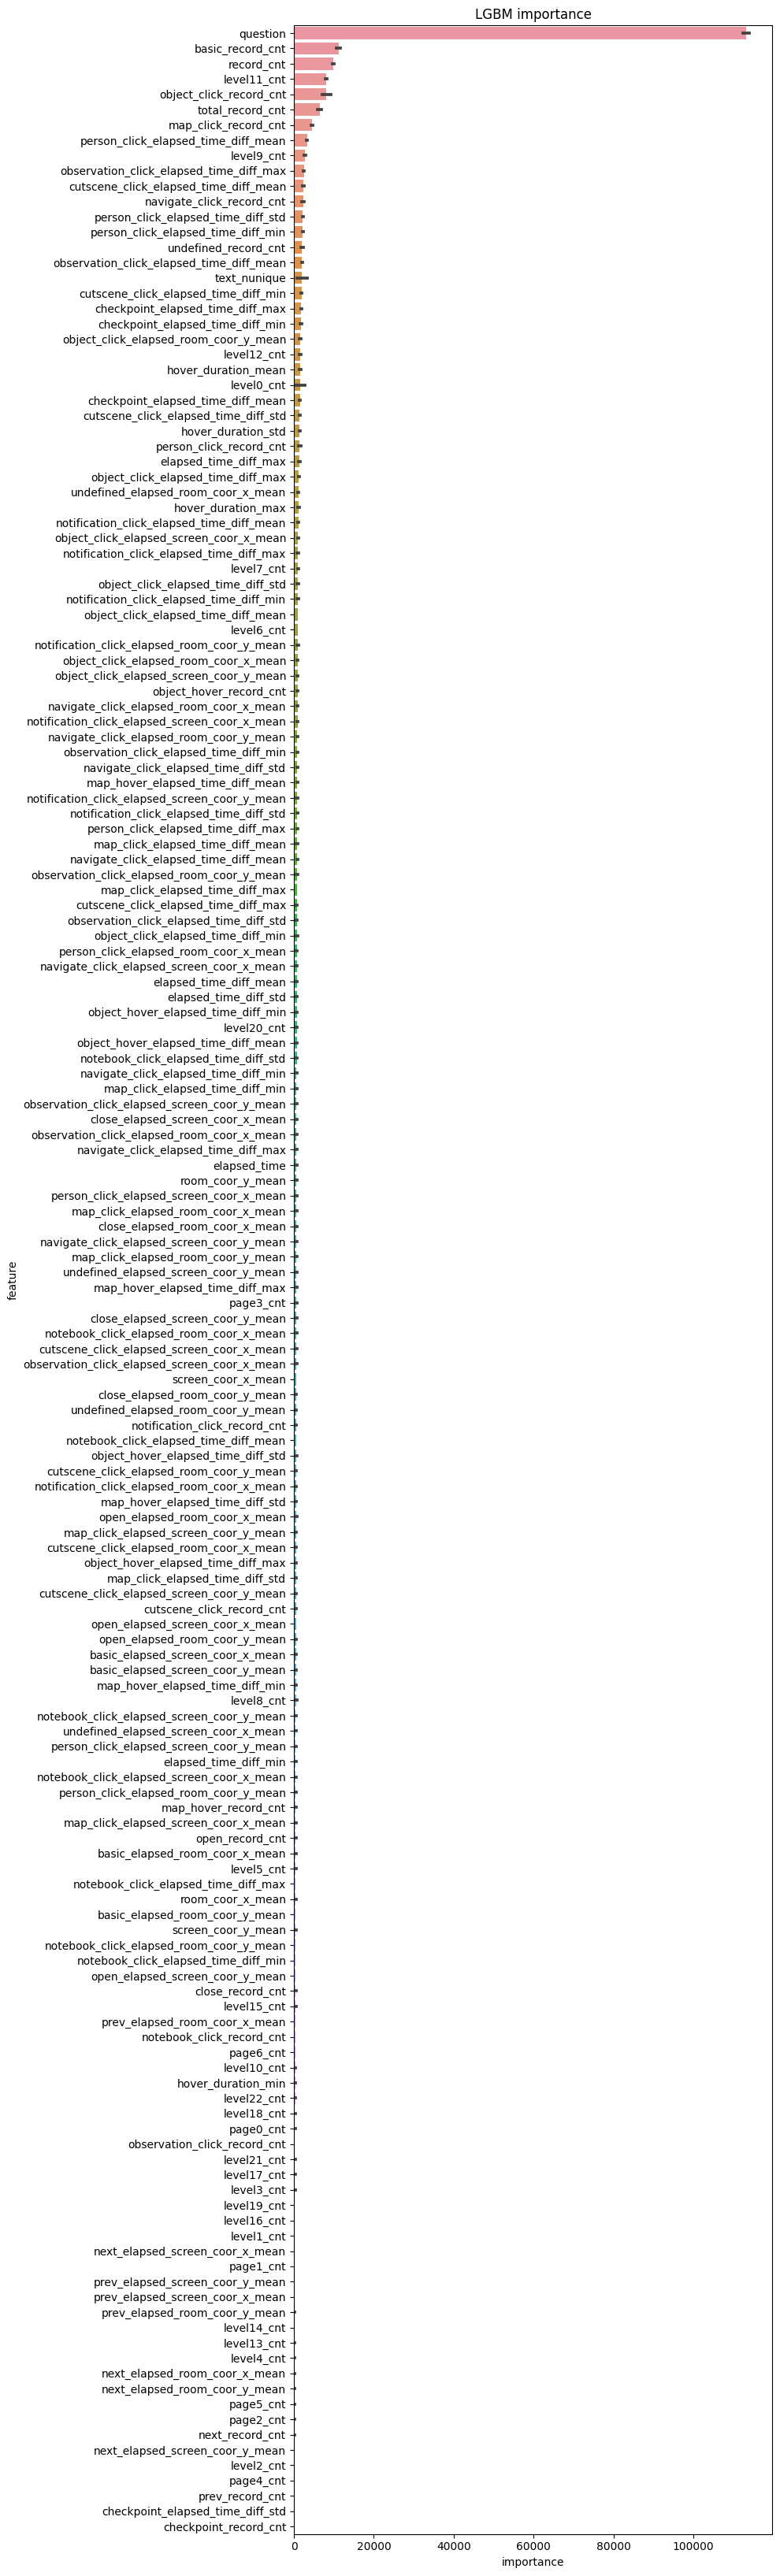

In [29]:
if cfg.mode == "local_cv":
    run_train()
inference(cfg.mode)